In [1]:
import sys 
from itertools import groupby
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.dont_write_bytecode = True

import HelperBunny as hb

np.set_printoptions(suppress=True)
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows     = 60
pd.options.display.max_columns  = 60

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# load data
loads items for analysis: a3m alignment, tmhmm, constraints

In [2]:
up_name, up_aln = hb.gen_array('data/up200402_tk261.a3m')
up_pos = up_aln[:,up_aln.is_position()]
up_name.parse_uniprot()

taxdump = hb.TaxonomyDatabase().load()
up_tax = taxdump.taxonomy(up_name['OX'])

up_name['rtk'] = pd.read_csv('data/up200402_tk.tmhmm', sep='\t', header=None, comment='#')
up_name['rtk'] = set(up_name['rtk'][0][up_name['rtk'][1]=='TMhelix'].values)
up_name['rtk'] = np.array([i in up_name['rtk'] for i in up_name['id']])
up_name['pseudo'] = np.array(['KDD'!=''.join(i) for i in up_aln.get_positions(33,128,146)])

con = hb.SequenceConstraints('data/tk261_consensus.con')
up_con, up_sco = con.fit(up_aln)
up_name['constraints'] = np.array(['|'.join(np.array(up_con)[i]) for i in (up_sco>0.7).T], dtype=object)

FILTER = ((up_pos=='-').sum(1)<50)
HASCON = (up_sco>0.7).any(axis=0)

print(f'total seq       : {up_aln.shape[0]}')
print(f'has < 50 gaps   : {FILTER.sum()}')
print(f'has constraints : {HASCON.sum()}')
print(f'overlap         : {(FILTER*HASCON).sum()}')
up_tax

total seq       : 44639
has < 50 gaps   : 38603
has constraints : 34363
overlap         : 33631


<Species: 44639 sequences in 586 species (440 unknown)>

# cluster summary
table describing basic stats for each constraint-defined cluster; uses tmhmm to define rtks; uses KDD triad to define pseudokinases (or non-cannonical kinases)

In [3]:
def analysis():
    start  = np.where(up_aln.alignment_positions() == 91)[0][0]
    end    = np.where(up_aln.alignment_positions() == 100)[0][0]
    genlen = lambda x: sum(1 for k in filter(lambda y: y!='-', (j for i in x for j in i)))
    insert = np.array(list(map(genlen, up_aln[:,start:1+end])))
    
    x = []
    f = lambda x: "%.2f%%" % (x * 100)
    p = lambda x: f(x / FILTER.sum())
    for name, mask in zip(up_con, up_sco>0.7):
        cnt = mask[FILTER].sum()
        rtk = up_name['rtk'][FILTER * mask].sum()
        psk = up_name['pseudo'][FILTER * mask].sum()
        dei = int(np.median(insert[FILTER * mask]))
        x  += [[name, cnt, p(cnt), rtk, f(rtk/cnt), psk, f(psk/cnt), dei]]
        
    name, mask = 'unclassified', ~(up_sco>0.7).any(0)
    cnt = mask[FILTER].sum()
    rtk = up_name['rtk'][FILTER * mask].sum()
    psk = up_name['pseudo'][FILTER * mask].sum()
    dei = int(np.median(insert[FILTER * mask]))
    x  += [[name, cnt, p(cnt), rtk, f(rtk/cnt), psk, f(psk/cnt), dei]]
    
    x = pd.DataFrame(x, columns=['cluster','count','%total','rtk','%rtk','pseudo','%pseudo','DE insertion'])
    
    return x

analysis()

,cluster,count,%total,rtk,%rtk,pseudo,%pseudo,DE insertion
0,SrcM,4850,12.56%,0,0.00%,86,1.77%,9
1,Tec,1085,2.81%,0,0.00%,15,1.38%,9
2,Abl,863,2.24%,0,0.00%,12,1.39%,9
3,Frk,342,0.89%,0,0.00%,12,3.51%,9
4,SrcA,1336,3.46%,0,0.00%,31,2.32%,9
5,SrcB,988,2.56%,0,0.00%,12,1.21%,9
6,Csk,698,1.81%,0,0.00%,5,0.72%,9
7,Src-Aque1,20,0.05%,0,0.00%,20,100.00%,8
8,SRM,166,0.43%,0,0.00%,6,3.61%,9
9,Fer,1208,3.13%,0,0.00%,37,3.06%,8


# cluster similarity
cluster to cluster similarity. code includes implementation of the algorithm distance calculations. note that this metric does not exhibit bi-directional equality

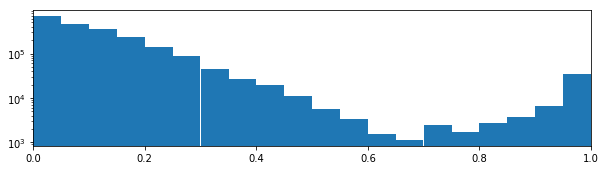

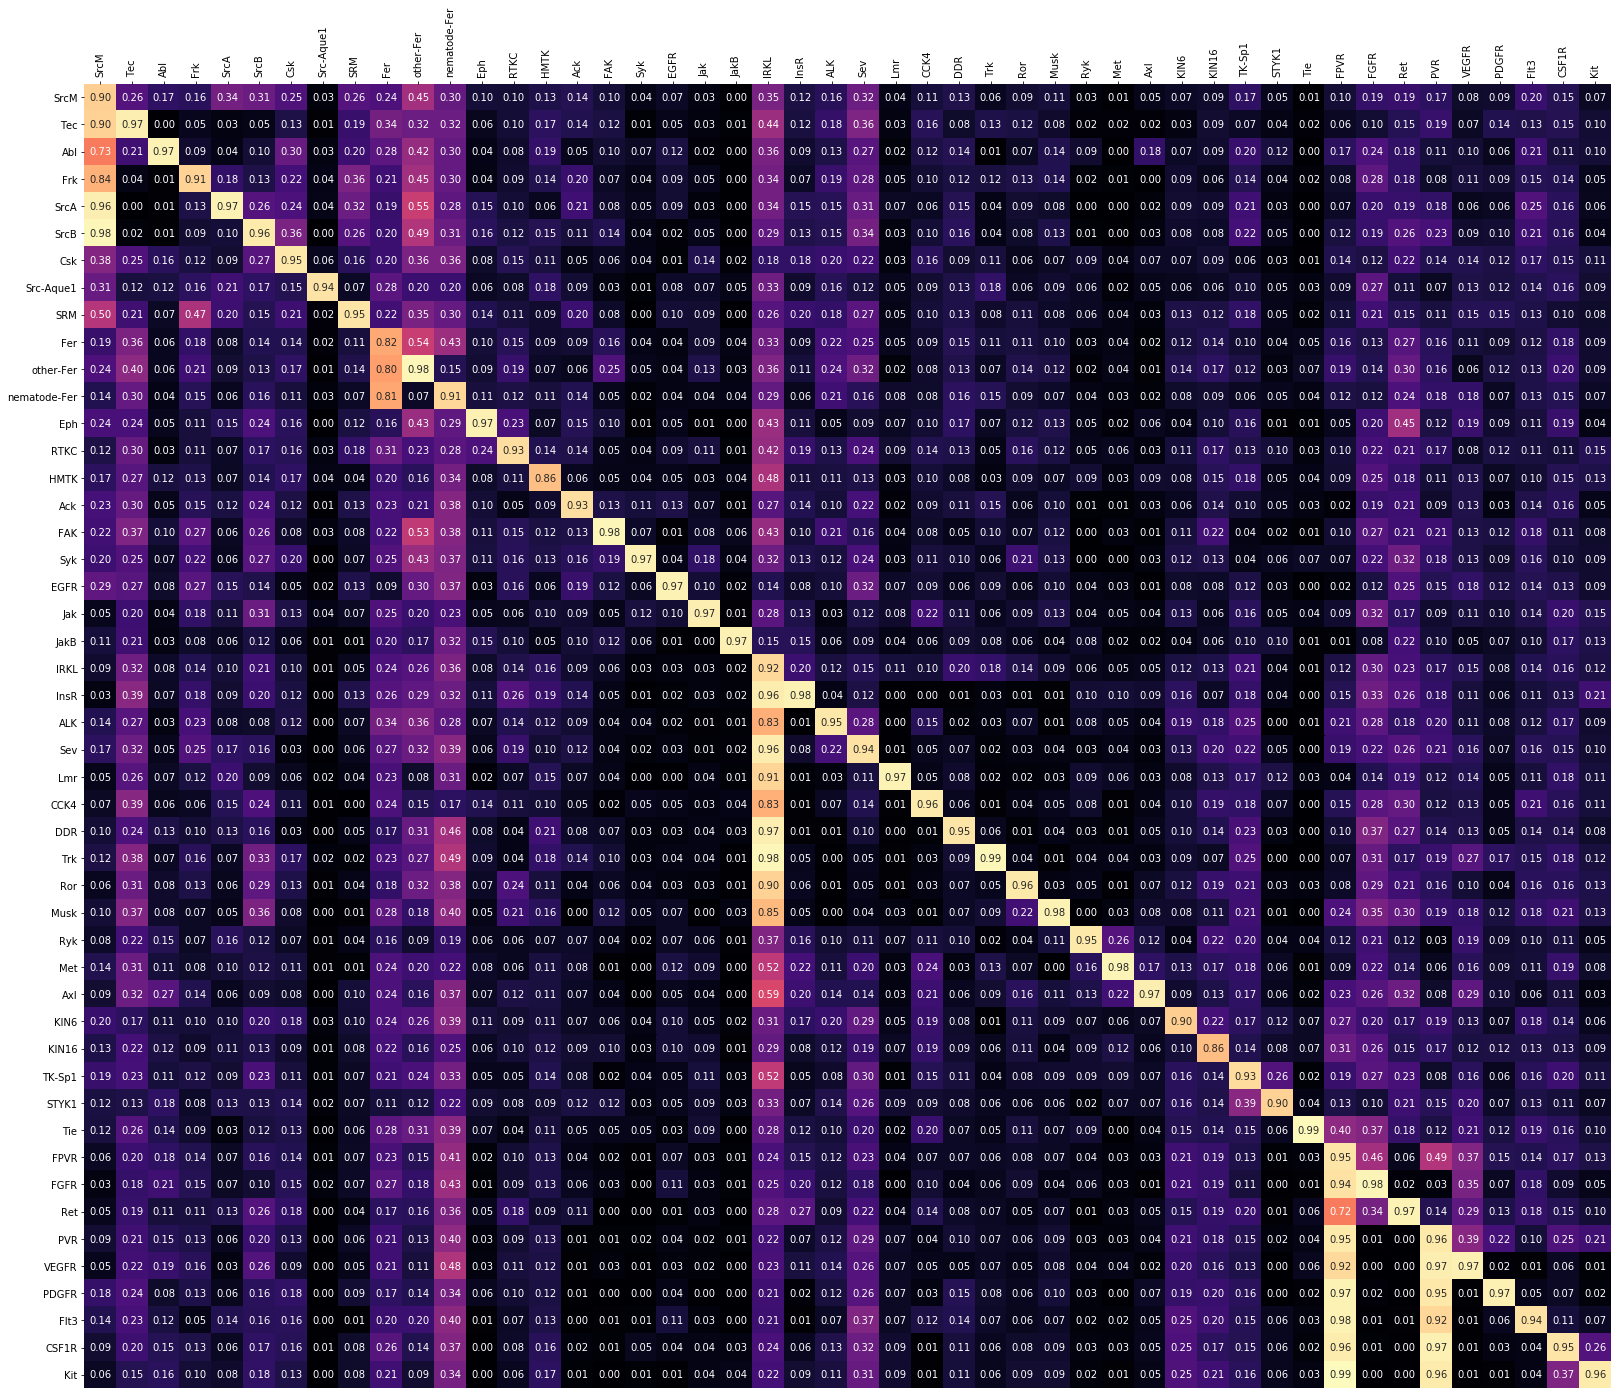

In [4]:
def analysis():
    plt.figure(figsize=(10,2.5))
    plt.hist(up_sco.flatten(), bins=20, log=True)
    plt.xlim(0,1); plt.show()
    
    df = pd.DataFrame(
        {constraint: dict(zip(up_con, up_sco.T[FILTER*mask].mean(axis=0)))
        for constraint, mask in zip(up_con, up_sco>0.7)})
    df = df[up_con].T[up_con]
    
    def df2heatmap(df):
        scale   = np.array([0.57, 0.5])
        dim     = np.array(df.shape[::-1])
        fig, ax = plt.subplots(figsize=dim*scale)
        sns.heatmap(df.values, vmin=0, vmax=1,
                    cbar=False, cmap='magma', #linewidths=.2,
                    annot=True, fmt=".2f",
                    xticklabels=df.columns,
                    yticklabels=df.index)
        ax.xaxis.set_ticks_position('top')
        plt.xticks(rotation=90)
        
    df2heatmap(df)
    
analysis()

# taxonomic conservation (full)

In [5]:
def analysis():
    query = [
        'Ichthyosporea'   , # Holozoa: Ichthyosporea
        'Filasterea'      , # Holozoa: Filozoa: Filasterea
        'Choanoflagellata', # Holozoa: Filozoa: Choanozoa: Choanoflagellata
        'Porifera'        , # Holozoa: Filozoa: Choanozoa: Animalia: Porifera
        'Placozoa'        , # Holozoa: Filozoa: Choanozoa: Animalia: Placozoa
        'Cnidaria'        , # Holozoa: Filozoa: Choanozoa: Animalia: Cnidaria
        'Rotifera'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Mollusca'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Brachiopoda'     , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Annelida'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Platyhelminthes' , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Nematoda'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Arthropoda'      , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Tardigrada'      , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Echinodermata'   , # Holozoa: Filozoa: Choanozoa: Animalia: Deuteromia
        'Chordata'        , # Holozoa: Filozoa: Choanozoa: Animalia: Deuteromia
        ]
    
    con_name, con_mask = up_con.copy(), up_sco>0.7
    df = {}
    for taxon in query:
        tax   = up_tax[taxon] * FILTER
        nseq  = tax.sum()
        nspe  = len(set(up_tax.species[tax]))
        label = '%s\n(species %s)' % (taxon, nspe)
        
        hits  = con_mask.T[tax].sum(0)
        df[label] = dict(zip(con_name, hits))
        df[label]['Unclassified'] = nseq-(con_mask.T[tax].sum(1)>0).sum()
        
    df = pd.DataFrame(df).T[con_name+['Unclassified']].T
    display(df.T)
    
    def df2heatmap(df):
        dim     = np.array(df.shape[::-1])
        scale   = np.array([1.08, 0.32]) # width x height
        fig, ax = plt.subplots(figsize=dim * scale)
        sns.heatmap(df.values, cbar=False,
                    vmin=0, vmax=1, cmap='gray',
                    annot=True, fmt=".5g", 
                    linewidths=0.38, linecolor='lightgray',
                    xticklabels=df.columns,
                    yticklabels=df.index,
                   )
        ax.xaxis.set_ticks_position('top')
        plt.xticks(rotation=90)

analysis()

,SrcM,Tec,Abl,Frk,SrcA,SrcB,Csk,Src-Aque1,SRM,Fer,other-Fer,nematode-Fer,Eph,RTKC,HMTK,Ack,FAK,Syk,EGFR,Jak,JakB,IRKL,InsR,ALK,Sev,Lmr,CCK4,DDR,Trk,Ror,Musk,Ryk,Met,Axl,KIN6,KIN16,TK-Sp1,STYK1,Tie,FPVR,FGFR,Ret,PVR,VEGFR,PDGFR,Flt3,CSF1R,Kit,Unclassified
Ichthyosporea\n(species 1),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
Filasterea\n(species 1),6,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108
Choanoflagellata\n(species 2),7,1,0,0,0,0,2,0,0,0,0,0,0,18,19,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,165
Porifera\n(species 1),6,3,0,1,0,0,3,20,0,0,1,0,0,0,0,0,1,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123
Placozoa\n(species 2),5,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
Cnidaria\n(species 3),11,1,2,0,0,0,2,0,0,0,0,0,5,0,0,3,2,0,0,0,0,22,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,15,12,0,0,0,0,0,0,0,299
Rotifera\n(species 1),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
Mollusca\n(species 6),25,3,7,6,0,0,5,0,0,4,4,0,5,0,0,11,12,0,6,0,0,67,7,3,7,0,2,5,0,11,4,8,1,0,0,0,0,0,0,14,9,4,0,0,0,0,0,0,141
Brachiopoda\n(species 1),14,3,5,1,0,0,1,0,0,1,1,0,5,0,0,5,2,0,5,0,0,20,2,6,2,0,2,3,0,1,1,2,4,0,0,0,0,0,0,3,3,1,0,0,0,0,0,0,77
Annelida\n(species 2),6,2,1,1,0,0,3,0,0,1,1,0,3,0,0,2,2,0,5,0,0,16,1,1,2,0,1,2,0,1,1,1,0,0,0,0,0,0,0,5,7,1,0,0,0,0,0,0,69


# taxonomic conservation (abridged)

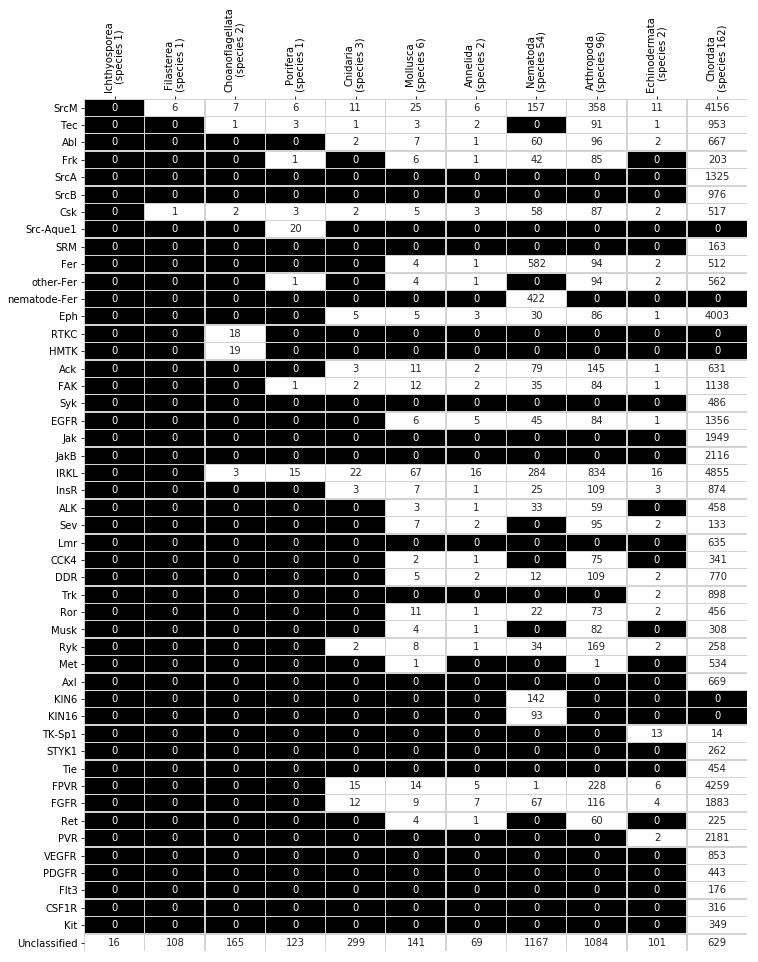

In [6]:
def analysis():
    query = [
        'Ichthyosporea'   , # Holozoa: Ichthyosporea
        'Filasterea'      , # Holozoa: Filozoa: Filasterea
        'Choanoflagellata', # Holozoa: Filozoa: Choanozoa: Choanoflagellata
        'Porifera'        , # Holozoa: Filozoa: Choanozoa: Animalia: Porifera
        'Cnidaria'        , # Holozoa: Filozoa: Choanozoa: Animalia: Cnidaria
        'Mollusca'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Annelida'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Nematoda'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Arthropoda'      , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Echinodermata'   , # Holozoa: Filozoa: Choanozoa: Animalia: Deuteromia
        'Chordata'        , # Holozoa: Filozoa: Choanozoa: Animalia: Deuteromia
        ]
    
    con_name, con_mask = up_con.copy(), up_sco>0.7
    df = {}
    for taxon in query:
        tax   = up_tax[taxon] * FILTER
        nseq  = tax.sum()
        nspe  = len(set(up_tax.species[tax]))
        label = '%s\n(species %s)' % (taxon, nspe)
        
        hits  = con_mask.T[tax].sum(0)
        df[label] = dict(zip(con_name, hits))
        df[label]['Unclassified'] = nseq-(con_mask.T[tax].sum(1)>0).sum()
        
    df = pd.DataFrame(df).T[con_name+['Unclassified']].T
    
    def df2heatmap(df):
        dim     = np.array(df.shape[::-1])
        scale   = np.array([1.08, 0.32]) # width x height
        fig, ax = plt.subplots(figsize=dim * scale)
        sns.heatmap(df.values, cbar=False,
                    vmin=0, vmax=1, cmap='gray',
                    annot=True, fmt=".5g", 
                    linewidths=0.38, linecolor='lightgray',
                    xticklabels=df.columns,
                    yticklabels=df.index,
                   )
        ax.xaxis.set_ticks_position('top')
        plt.xticks(rotation=90)
    
    df2heatmap(df)
    plt.show()

analysis()

# domain-taxonomy conservation


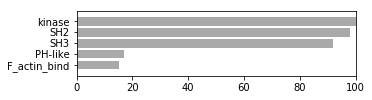

,Tec,Abl,Frk,SrcA,SrcB
kinase,1071,808,336,1334,1002
SH2,1045,798,320,1327,992
SH3,895,790,257,1316,953
PH-like,834,0,0,0,0
F_actin_bind,0,743,0,0,0


,Ichthyosporea,Filasterea,Choanoflagellata,Porifera,Cnidaria,Mollusca,Annelida,Nematoda,Arthropoda,Echinodermata,Chordata
kinase,0,6,7,6,11,25,6,160,351,11,4210
SH2,0,6,7,6,8,23,2,149,331,10,4159
SH3,0,6,7,5,8,17,1,140,299,9,3927
PH-like,0,1,2,1,1,1,1,0,34,1,782
F_actin_bind,0,0,0,0,0,6,1,41,69,1,610


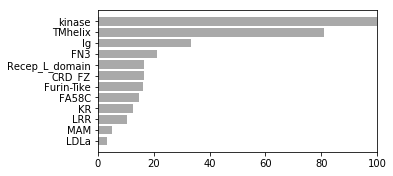

,InsR,ALK,Sev,Lmr,CCK4,DDR,Trk,Ror,Musk
kinase,1038,550,247,648,423,905,918,579,408
TMhelix,888,231,200,296,416,861,835,546,398
Ig,0,0,0,0,417,0,870,461,307
FN3,1012,0,216,0,0,0,0,0,0
Recep_L_domain,999,0,0,0,0,0,0,0,0
CRD_FZ,0,0,0,0,0,0,0,566,395
Furin-like,969,0,0,0,0,0,0,0,0
FA58C,0,0,0,0,0,856,0,0,0
KR,0,0,0,0,0,0,0,556,163
LRR,0,0,0,0,0,0,666,0,0


,Ichthyosporea,Filasterea,Choanoflagellata,Porifera,Cnidaria,Mollusca,Annelida,Nematoda,Arthropoda,Echinodermata,Chordata
kinase,0,0,3,15,23,71,18,291,850,16,4925
TMhelix,0,0,2,15,16,56,8,256,722,13,3957
Ig,0,0,0,7,5,16,3,38,107,5,1881
FN3,0,0,1,1,2,14,1,106,187,2,996
Recep_L_domain,0,0,2,0,2,5,1,55,107,2,853
CRD_FZ,0,0,0,1,9,17,1,60,166,2,750
Furin-like,0,0,0,0,2,5,1,54,103,0,829
FA58C,0,0,0,0,2,3,3,54,111,1,746
KR,0,0,0,1,4,17,1,61,170,2,520
LRR,0,0,0,0,0,2,1,0,1,0,651


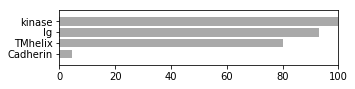

,FGFR,Ret,VEGFR,PDGFR,Flt3,CSF1R,Kit
kinase,2008,220,847,450,177,312,353
Ig,1971,0,837,444,162,310,350
TMhelix,1709,54,502,437,164,277,348
Cadherin,0,205,0,0,0,0,0


,Ichthyosporea,Filasterea,Choanoflagellata,Porifera,Cnidaria,Mollusca,Annelida,Nematoda,Arthropoda,Echinodermata,Chordata
kinase,0,0,0,0,15,14,5,1,229,6,4273
Ig,0,0,0,0,9,12,2,1,202,6,3988
TMhelix,0,0,0,0,9,12,3,1,205,6,3406
Cadherin,0,0,0,0,0,0,0,0,0,0,202


In [7]:
def setup():
    def iter_cdd(file):
        isq = lambda x: x.startswith('Q#')
        itr = lambda x: x.split(' ')[0]
        for g, i in groupby(filter(isq, open(file)),itr):
            yield list(i)

    def iter_tmhmm(file):
        d = {}
        for i in open(file):
            if '\tTMhelix\t' in i:
                i = i.strip().split('\t')
                if i[0] not in d:
                    d[i[0]] = []
                d[i[0]] += [tuple(map(int, i[-1].strip().split()))]
        return d

    class Domains:
        def __init__(self, cdd_lines, tmhmm={}):
            x = [i.split('\t') for i in cdd_lines]
            self.name    = x[0][0].split(' - >')[1].strip()
            self.domains = [(i[8], int(i[3]), int(i[4])) for i in x]
            if self.name in tmhmm:
                self.domains += [('TMhelix',i,j) for i,j in tmhmm[self.name]]
            self.sort_domains()

        def remove_domains(self, remove=[]):
            self.domains = [i for i in self.domains if i[0] not in remove]

        def sort_domains(self):
            self.domains.sort(key=lambda x: (x[1]+x[2])/2)

        def get_domains(self, tr={}, norepeat=True, remove=[]):
            nosuper = lambda x: x.replace(' superfamily', '').replace('_superfamily', '')
            d = [nosuper(i[0]) for i in self.domains]
            d = [i for i in d if i not in remove]
            if norepeat:
                d = tuple(tr[i] if i in tr else i for i in d)
                d = [i[0] for i in groupby(d)]
            else:
                d = tuple(tr[i] if i in tr else i for i in d)
            # clean up TMhelix
            d = d[1: ] if (d.count('TMhelix')>1 and d[ 0]=='TMhelix') else d
            d = d[:-1] if (d.count('TMhelix')>1 and d[-1]=='TMhelix') else d
            return d

    ########################
    
    dic_tmhmm = iter_tmhmm('data/up200402_tk.tmhmm')
    it_cdd    = iter_cdd('data/up200402_tk.cdd')

    domain_translate = {
        'Pkinase_Tyr'  : 'kinase',
        'STYKc'        : 'kinase',
        'PKc_like'     : 'kinase',
        'TPKR_C2'      : 'Ig',
        'IG'           : 'Ig',
        'SH3_10'       : 'SH3',
        'LRR_8'        : 'LRR',
        'LRRNT'        : 'LRR',
        'LRRCT'        : 'LRR',
        'RET_CLD1'     : 'Cadherin',
        'RET_CLD3'     : 'Cadherin',
        'RET_CLD4'     : 'Cadherin',
        'Insulin_TMD'  : 'TMhelix',
        'TM_EGFR-like' : 'TMhelix',
        'TM_EphA1'     : 'TMhelix',
        'TrkA_TMD'     : 'TMhelix',
        'TMEM154'      : 'TMhelix',
        'FGFR3_TM'     : 'TMhelix',
        'VEGFR-2_TMD'  : 'TMhelix',   
        }

    domain_remove = set(
        ['Insulin_TMD',
         'TM_EGFR-like',
         'TM_EphA1',
         'TrkA_TMD',
         'TMEM154',
         'FGFR3_TM',
         'VEGFR-2_TMD'])

    ########################
    
    domains = [] 
    for i in it_cdd:
        obj = Domains(i, tmhmm=dic_tmhmm)
        dom = obj.get_domains(norepeat=True, remove=domain_remove, tr=domain_translate)
        acc = obj.name.split()[0]
        domains += [[acc, dom]]
        
    return domains

def analysis():
    domains = setup()
    _up_con = np.array(up_con, dtype=object)
    tax_q   = np.array([
        'Ichthyosporea'   , # Holozoa: Ichthyosporea
        'Filasterea'      , # Holozoa: Filozoa: Filasterea
        'Choanoflagellata', # Holozoa: Filozoa: Choanozoa: Choanoflagellata
        'Porifera'        , # Holozoa: Filozoa: Choanozoa: Animalia: Porifera
        'Cnidaria'        , # Holozoa: Filozoa: Choanozoa: Animalia: Cnidaria
        'Mollusca'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Annelida'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Spiralia
        'Nematoda'        , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Arthropoda'      , # Holozoa: Filozoa: Choanozoa: Animalia: Protostomia : Ecdysozoa
        'Echinodermata'   , # Holozoa: Filozoa: Choanozoa: Animalia: Deuteromia
        'Chordata'        , # Holozoa: Filozoa: Choanozoa: Animalia: Deuteromia
        ], dtype=object)
    
    d   = {i[1]:i[0] for i in enumerate(up_name['accession'])}
    ind = np.array([d[i[0]] for i in domains]) # apply this mask before using any of the masks here
    dom = np.array([i[1] for i in domains], dtype=object)
    con = np.array([_up_con[i].tolist() for i in (up_sco.T>0.7)[ind]], dtype=object)
    tax = np.array([tax_q[i][0] if any(i) else None for i in np.array([up_tax[i] for i in tax_q]).T], dtype=object)[ind]
    
    #############

    masks = {} # for sequence queries later
    sgs   = {
        'SrcM': ['Tec','Abl','Frk','SrcA','SrcB'],
        'IRKL': ['InsR','ALK','Sev','Lmr','CCK4','DDR','Trk','Ror','Musk'],
        'FPVR': ['FGFR','Ret','VEGFR','PDGFR','Flt3','CSF1R','Kit']}
    for cluster in sgs:
        cutoff = 3 # percent
        mask = np.array([cluster in i for i in con])
        domp = sorted((sum(i in j for j in dom[mask]), i) for i in set(j for i in dom[mask] for j in i))
        domp = list(filter(lambda x:x[0]>cutoff,((round(i/mask.sum()*100,2),j) for i, j in domp[::-1])))
        
        plt.figure(figsize=(5,(1+len(domp))/5))
        plt.barh(*zip(*enumerate(i[0] for i in domp[::-1])), tick_label=[i[1] for i in domp[::-1]], color='darkgray')
        plt.ylim(-1, len(domp)); plt.xlim(0,100)
        plt.show()
        
        cross = lambda x, y: {i: np.array([i in j for j in y]) for i in x}
        
        o_con = sgs[cluster]
        o_dom = [i[1] for i in domp]
        o_tax = tax_q
        x_con = cross(sgs[cluster], con)
        x_dom = cross([i[1] for i in domp], dom)
        x_tax = {i: i==tax for i in tax_q}
        x_sgs = cross([cluster], con)
        
        masks.update({**x_con, **x_dom, **x_tax, **x_sgs})
        
        df = {cn:{dn:(dm*cm*x_sgs[cluster]).sum() for dn, dm in x_dom.items()} for cn, cm in x_con.items()}
        df = pd.DataFrame(df)[o_con].T[o_dom].T
        display(df)
        
        df = {cn:{dn:(dm*cm*x_sgs[cluster]).sum() for dn, dm in x_dom.items()} for cn, cm in x_tax.items()}
        df = pd.DataFrame(df)[o_tax].T[o_dom].T
        display(df)
    
    # (ind, masks) : can be used to query specific groups
    return 

analysis() 

# longde / shortde

longde  : 13917
shortde : 19714


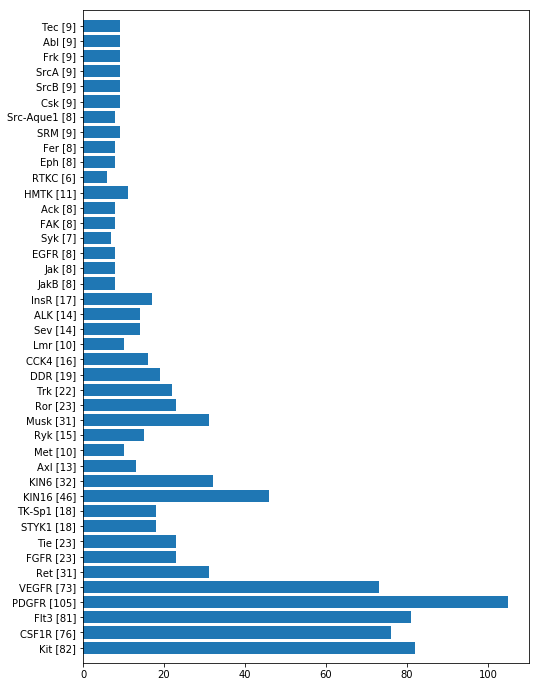

In [8]:
def analysis():
    shortde = ['SrcM','Tec','Abl','Frk','SrcA','SrcB','Csk','Src-Aque1','SRM','Fer',
          'other-Fer','nematode-Fer','Eph','RTKC','HMTK','Ack','FAK','Syk','EGFR','Jak','JakB']
    longde  = ['IRKL','InsR','ALK','Sev','Lmr','CCK4','DDR','Trk','Ror','Musk','Ryk',
          'Met','Axl','KIN6','KIN16','TK-Sp1','STYK1','Tie','FPVR','FGFR','Ret',
          'PVR','VEGFR','PDGFR','Flt3','CSF1R','Kit']    
    
    mask_sd = np.array([i in shortde for i in up_con])
    mask_ld = np.array([i in longde for i in up_con])
                       
    print(f'longde  : {(up_sco>0.7)[mask_ld][:,FILTER].any(0).sum()}')
    print(f'shortde : {(up_sco>0.7)[mask_sd][:,FILTER].any(0).sum()}')
    
    start  = np.where(up_aln.alignment_positions() == 91)[0][0]
    end    = np.where(up_aln.alignment_positions() == 100)[0][0]
    insert = up_aln[:,start:1+end]
    
    genlen = lambda x: sum(1 for k in filter(lambda y: y!='-', (j for i in x for j in i)))
    inslen = np.array(list(map(genlen, insert)))
    
    n, x, y, lab = 0, [], [], []
    for name, mask in zip(up_con, up_sco>0.7):
        if name in ['SrcM','other-Fer','nematode-Fer','IRKL','FPVR','PVR']: continue
        insmed = int(np.median(inslen[FILTER * mask]))
        n   += 1
        x   += [n]
        y   += [insmed]
        lab += ['%s [%s]' % (name, insmed)]
    
    plt.figure(figsize=(8,12))
    plt.ylim(min(x)-1,1+max(x))
    plt.barh(x, y[::-1], tick_label=lab[::-1])
    plt.show()

analysis()

# its over